# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*

[For info about what Sobol is.](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis)



In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging, Policy)

from ema_workbench.em_framework.evaluators import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework import get_SALib_problem


from problem_formulation import get_model_for_problem_formulation

from SALib.analyze import sobol

C:\Users\ludov\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(


In [3]:
# usual setup
ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(0)

In [4]:
# create some random policies

# policy 1
one_policy = {'DaysToThreat': 1} # 0 to 4
one_policy.update({'DikeIncrease {}'.format(n): 1 for n in planning_steps}) # o to 10
one_policy.update({'RfR {}'.format(n): 1 for n in planning_steps}) # 0 to 1
pol1 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split('_')
    pol1.update({key.name: one_policy[s2]})

policy1 = Policy('Policy 1', **pol1)

# policy 2
two_policy = {'DaysToThreat': 2}
two_policy.update({'DikeIncrease {}'.format(n): 2 for n in planning_steps})
two_policy.update({'RfR {}'.format(n): 1 for n in planning_steps})
pol2 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split('_')
    pol2.update({key.name: two_policy[s2]})

policy2 = Policy('Policy 2', **pol2)


# policy 3
three_policy = {'DaysToThreat': 3}
three_policy.update({'DikeIncrease {}'.format(n): 3 for n in planning_steps})
three_policy.update({'RfR {}'.format(n): 1 for n in planning_steps})
pol3 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split('_')
    pol3.update({key.name: three_policy[s2]})

policy3 = Policy('Policy 3', **pol3)

In [5]:
policies = [policy1, policy2, policy3]

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)

N = 3

with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, results = evaluator.perform_experiments(N, policies,
                                                         uncertainty_sampling=Samplers.SOBOL)
# since it's sobol we are going to have N * (n_uncertanties * 2 + 2) scenarios

[MainProcess/INFO] pool started with 4 workers
C:\Users\ludov\anaconda3\lib\site-packages\SALib\sample\saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (3) is equal to `2^n`.
        
  warnings.warn(msg)
[MainProcess/INFO] performing 120 scenarios * 3 policies * 1 model(s) = 360 experiments
100%|████████████████████████████████████████| 360/360 [11:26<00:00,  1.91s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [7]:
problem = get_SALib_problem(dike_model.uncertainties)
problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [8]:
from SALib.analyze.sobol import analyze

In [10]:
sobol_results = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = results['All Costs'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

In [11]:
indices

{'S1': array([ 0.00591978,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.59458856,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.00792906,  0.        ,  0.        ,
         0.14645596,  0.        ,  0.0362484 ,  0.        ]),
 'S1_conf': array([10.70136778,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.76187304,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 11.39035355,  0.        ,  0.        ,
        10.74357065,  0.        ,  0.04561537,  0.        ]),
 'ST': array([6.49571333e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.30399204e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.85883949e-04, 0.00000000e+00, 0.00000000e+00, 1.24995138e-01,
        0.00000000e+00, 4.82837530e-03, 0.00000000e+00]),
 'ST_conf': array([0.36250018, 0.        , 0.        , 0.        , 0.

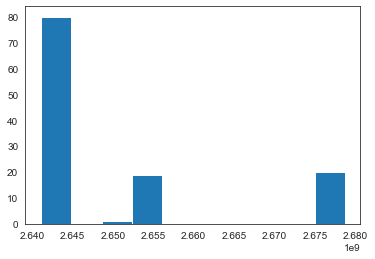

In [12]:
plt.hist(y)
plt.show()

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*

[For info about random trees](https://quantdare.com/random-forest-many-are-better-than-one/)</br>
For info about random trees and extra trees: [link](https://towardsdatascience.com/an-intuitive-explanation-of-random-forest-and-extra-trees-classifiers-8507ac21d54b), [link](https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/)

In [13]:
from ema_workbench.analysis import feature_scoring

In [14]:
cleaned_experiments = experiments.drop(columns=[l.name for l in dike_model.levers])

scores = feature_scoring.get_feature_scores_all(cleaned_experiments,results)

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


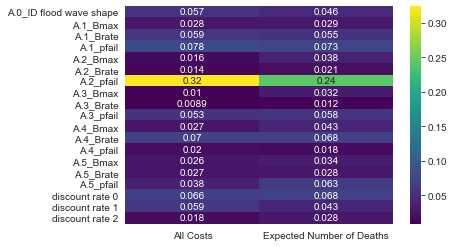

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


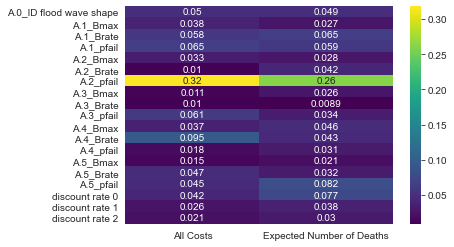

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


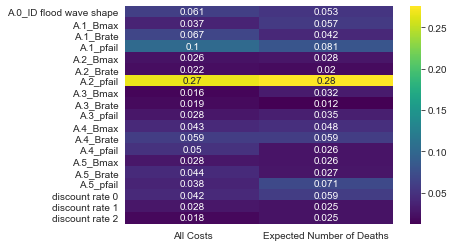

In [15]:
import seaborn as sns
cleaned_experiments = experiments.drop(columns=[l.name for l in dike_model.levers])

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    subset_results = {k:v[logical] for k,v in results.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

<font color=blue> Are these the SOBOL scores for the uncertanties & for both outcomes (whereas in the Assignment 6 we computed the scores only concerning one outcome?</font>

In [16]:
import statsmodels

In [17]:
y = results['All Costs']
x = cleaned_experiments.drop(columns=['scenario', 'policy', 'model'])

model = statsmodels.regression.linear_model.OLS(y, x.values)
fitted = model.fit()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [15]:
fitted.params

array([ 2.01862814, -0.51308185, -6.39992028,  0.19213615, -4.42897717])

In [ ]:
y = np.a(outcome[:, 1::] < outcome[:, 0], axis=1)